<a href="https://colab.research.google.com/github/butoialexandra/Realistic-looking-rainfall-forecasts/blob/Alex/verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Verification measures




In [5]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive')

Mounted at /content/drive


In [3]:
!pip install pysteps pyproj properscoring xarray 

     |████████████████████████████████| 10.9MB 4.3MB/s 


In [7]:
!pip install netcdf4

     |████████████████████████████████| 4.3MB 5.2MB/s 
     |████████████████████████████████| 296kB 45.7MB/s 


In [9]:
!pip install zarr

     |████████████████████████████████| 133kB 7.9MB/s 
     |████████████████████████████████| 5.8MB 7.0MB/s 
  Created wheel for asciitree: filename=asciitree-0.3.3-cp36-none-any.whl size=5037 sha256=258a35f534c184f38b902a0eaafaa75ac19081efa7ba4a28801db52edb04f4f8
  Stored in directory: /root/.cache/pip/wheels/1d/d9/58/9808b306744df0208fccc640d3d9952a5bc7468502d42897d5
Successfully built asciitree


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import pyproj
import properscoring as ps
import xarray as xr
from scipy.spatial import cKDTree

In [10]:
combi = xr.open_mfdataset("combiprecip_201805.nc", combine='by_coords') # CombiPrecip
cosmo = xr.open_zarr("cosmoe_prec_201805.zarr") # COSMO-E

Transform coordinate system

In [11]:
# Transform to Swiss coordinate system
src_proj = pyproj.Proj("EPSG:4326") # WSG84
dst_proj = pyproj.Proj("EPSG:21781") # CH1903 / LV03 
src_x = cosmo.lon.values
src_y = cosmo.lat.values
dst_x, dst_y = pyproj.transform(src_proj, dst_proj, src_x, src_y, always_xy=True)
cosmo = cosmo.assign_coords({"chx": (("y", "x"), dst_x) , "chy": (("y", "x"), dst_y)})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  


Select the same area for both datasets

In [12]:
pred_points = cosmo.isel(reftime=0, leadtime=1)
chx, chy = pred_points['chx'], pred_points['chy']
# These are the actual predictions (ensemble_cnt, x_len, y_len)
pred_points.PREC.values.shape

(21, 127, 188)

In [13]:
real_points = combi.isel(time=0, dummy=0).sel(chx=chx, chy=chy, method='nearest')
# These are the observations that are closest to our predictions.
# Note that the shape is the same as the shape of predictions
#  with the ensemble dimension removed.
real_points.RR.values.shape

(127, 188)

In [27]:
real_points.RR

<xarray.DataArray 'RR' (y: 127, x: 188)>
dask.array<reshape, shape=(127, 188), dtype=float32, chunksize=(127, 188), chunktype=numpy.ndarray>
Coordinates:
    dummy     float64 1.0
    chx       (y, x) float64 4.495e+05 4.525e+05 ... 8.555e+05 8.575e+05
    chy       (y, x) float64 3.95e+04 3.95e+04 3.95e+04 ... 3.325e+05 3.335e+05
    time      datetime64[ns] 2018-05-01T01:00:00
    lon       (y, x) float32 dask.array<chunksize=(127, 188), meta=np.ndarray>
    lat       (y, x) float32 dask.array<chunksize=(127, 188), meta=np.ndarray>
    leadtime  timedelta64[ns] 01:00:00
    reftime   datetime64[ns] 2018-05-01
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 180 181 182 183 184 185 186 187
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 119 120 121 122 123 124 125 126
Attributes:
    units:         mm
    grid_mapping:  swiss_coordinates
    long_name:     precipitation amount
    grid_name:     swisscors
    version:       no version
    prod_date:     2020-09-15

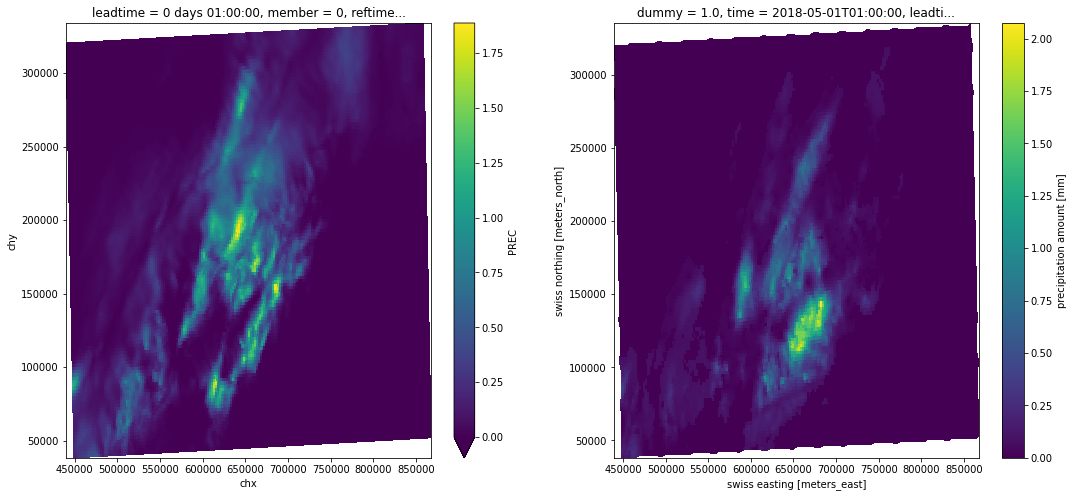

In [14]:
# Plot predictions on the left and observations on the right
fig, axes = plt.subplots(ncols=2, figsize=(18,8))
pred_points.PREC.isel(member=0).plot.pcolormesh("chx", "chy", ax=axes[0], cmap='viridis', vmin=0)
real_points.RR.plot.pcolormesh("chx", "chy", ax=axes[1])

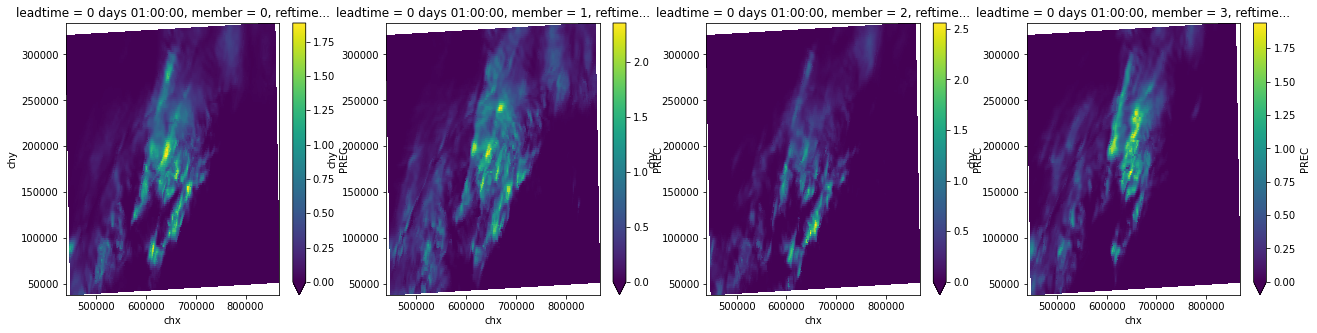

In [17]:
# Plot forecast from multiple members of the ensemble
fig, axes = plt.subplots(ncols=4, figsize=(22,5))
for i in range(4):
  pred_points.PREC.isel(member=i).plot.pcolormesh("chx", "chy", ax=axes[i], cmap='viridis', vmin=0)

Reliability diagram

In [22]:
from pysteps.postprocessing import ensemblestats
from pysteps import verification

In [47]:
probs = ensemblestats.excprob(pred_points.PREC, 0.01, ignore_nan=True)
probs.shape

(127, 188)

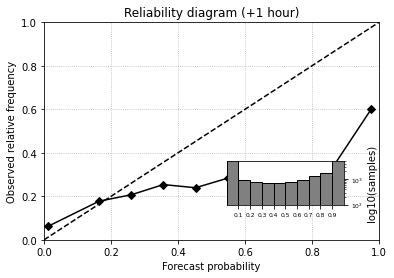

In [48]:
# Plot reliability diagram
reldiag = verification.reldiag_init(0.01)
verification.reldiag_accum(reldiag, probs, real_points.RR.values)
fig, ax = plt.subplots()
verification.plot_reldiag(reldiag, ax)
ax.set_title("Reliability diagram (+1 hour)")
plt.show()

Rank Histogram

In [49]:
n_members = pred_points.PREC.values.shape[0]
n_members

21

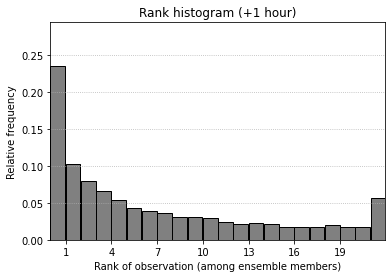

In [50]:
rankhist = verification.rankhist_init(n_members, 0.01)
verification.rankhist_accum(rankhist, pred_points.PREC.values, real_points.RR.values)
fig, ax = plt.subplots()
verification.plot_rankhist(rankhist, ax)
ax.set_title("Rank histogram (+1 hour)")
plt.show()

Continuous Rank Probability Score (CRPS)

In [51]:
crps = verification.probscores.CRPS_init()
verification.probscores.CRPS_accum(crps, pred_points.PREC.values, real_points.RR.values)
verification.probscores.CRPS_compute(crps)

0.06763725465130492